# MDL DB roll decay content
What is the data in the roll decay database and roll damping database?

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [71]:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 9

import data
import copy
from mdldb.mdl_db import MDLDataBase
from mdldb.tables import Base, Model, LoadingCondition, Run, RolldecayLinear, RolldecayDirect, RolldecayNorwegian
from mdldb.tables import Min, Mean, Max, Std, Ship
from mdldb import mdl_to_evaluation
from evaluation.run_dynamic import RunDynamic
from evaluation.run_manoeuvring import RunZigZag

from rolldecayestimators.direct_estimator import DirectEstimator
from rolldecayestimators.direct_linear_estimator import DirectLinearEstimator
from rolldecayestimators.norwegian_estimator import NorwegianEstimator
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
#from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from sklearn.pipeline import Pipeline

import signal_lab
from sqlalchemy.inspection import inspect
import seaborn as sns
import docs

In [3]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///' + data.mdl_db_path)
db = MDLDataBase(engine=engine)

In [4]:
roll_decay_tests = db.session.query(Run).filter((Run.id==Min.run_id) & 
                                                (Run.test_type=='roll decay'))

In [5]:
len(roll_decay_tests.all())

407

In [6]:
ships = db.session.query(Ship).filter((Run.id==Min.run_id) & 
                                                (Run.test_type=='roll decay'))

In [35]:
df_ships = pd.DataFrame()

for ship in ships:
    instance = inspect(ship)
    
    s = pd.Series()
                
    for key,item in instance.attrs.items():
        if not isinstance(item.value, list):
            if pd.notnull(item.value):
                s[key]=item.value
    
    df_ships = df_ships.append(s, ignore_index=True)

In [36]:
mask = df_ships[['lpp','beam','BKL','BKB']].notnull().all(axis=1)
df_ships = df_ships.loc[mask].copy()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1643CFD0>,
      dtype=object)

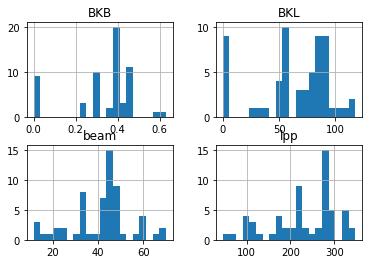

In [39]:
df_ships.hist(column = ['lpp','beam','BKL','BKB'],bins=20)

In [40]:
roll_decay_test = roll_decay_tests[0]

In [41]:
tables = ['min','mean','max','std']
statistics = {}
for table in tables:
    statistics[table] = pd.read_sql_table(table_name=table, con=engine)

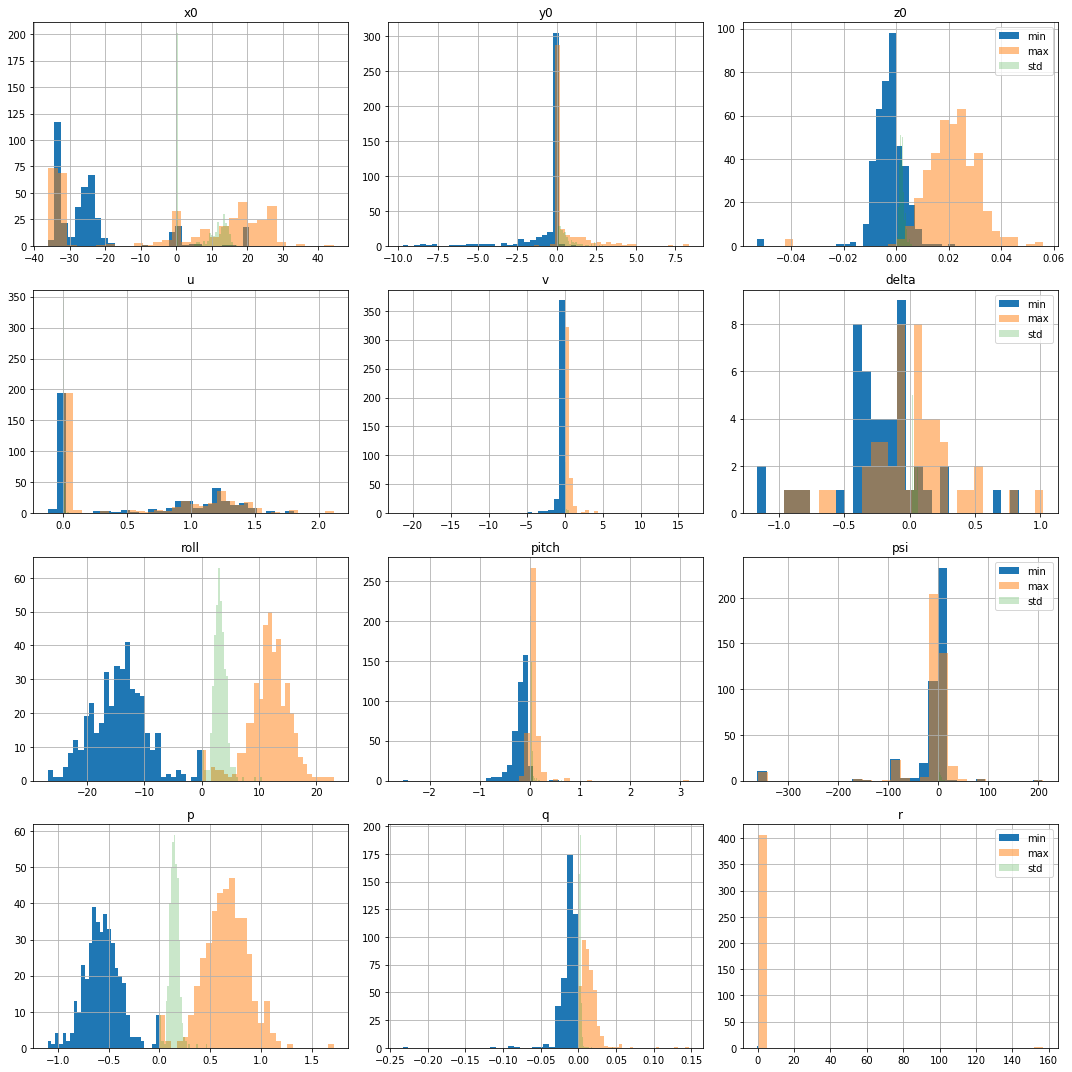

In [42]:
plots = [['x0','y0','z0'],
         ['u','v','delta'],
         ['roll','pitch','psi'],
         ['p','q','r']]
nrows = len(plots)
ncols = 0
for subplots in plots:
    if len(subplots) > ncols:
        ncols = len(subplots)

fig,axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(15,15)

for row, subplots in enumerate(plots):
    for col, plot in enumerate(subplots):
        
        ax = axes[row,col]
        min = statistics['min']
        max = statistics['max']
        std = statistics['std']
        
        bins = 30
        min[plot].hist(label='min', bins=bins, ax=ax)
        max[plot].hist(label='max', bins=bins, ax=ax, alpha=0.5)
        std[plot].hist(label='std', bins=bins, ax=ax, alpha=0.25)
        
        
        ax.set_title(plot)

    ax.legend()
plt.tight_layout()

### Comments
* All values above are in model scale. 
* Speed up to 2 m/s in model scale
* Rudder angle ($\delta$) is not used during test, but can have fixed initial angle to keep the model on a straight course.
* Max roll can be up to 25 degrees!
* The pitch is static (no standard deviation) so it is basically trim due to speed
* p, q and r are rotational velocities for roll, pitch and yaw.


In [43]:
cols = ['roll','psi','u','r']
min[cols].describe()

,roll,psi,u,r
count,407.000000,407.000000,407.000000,407.000000
mean,-14.354498,-17.665514,0.550688,-0.018214
std,4.852812,61.347784,0.603502,0.011007
min,-26.860000,-361.619797,-0.122843,-0.067245
25%,-17.305000,-4.765744,-0.013846,-0.023998
50%,-14.160000,-0.719400,0.279571,-0.016032
75%,-11.415000,-0.032600,1.174762,-0.009942
max,0.005000,207.702791,2.018690,-0.002182


In [44]:
max[cols].describe()

,roll,psi,u,r
count,407.000000,407.000000,407.000000,407.000000
mean,11.733146,-10.616949,0.594980,0.406797
std,3.665115,60.102102,0.613089,7.785212
min,0.000900,-360.046997,0.002522,0.002182
25%,9.965000,-0.057686,0.012196,0.010908
50%,11.980000,0.734857,0.301464,0.017964
75%,14.070000,2.925701,1.216718,0.028362
max,23.000000,210.517791,2.117975,157.081401


In [45]:
std[cols].describe()

,roll,psi,u,r
count,406.000000,407.000000,407.000000,407.000000
mean,3.098627,1.740753,0.006957,0.012714
std,1.154276,2.450445,0.013807,0.153974
min,0.000191,0.002432,0.000956,0.000230
25%,2.433426,0.250915,0.002915,0.002489
50%,3.031317,0.656507,0.004814,0.004314
75%,3.732001,2.077588,0.007300,0.006954
max,10.478363,13.044742,0.232787,3.110646


In [46]:
rolldecay_linear = pd.read_sql_table(table_name='rolldecay_linear', con=engine, index_col='run_id')
rolldecay_direct = pd.read_sql_table(table_name='rolldecay_direct', con=engine, index_col='run_id')
rolldecay_norwegian = pd.read_sql_table(table_name='rolldecay_norwegian', con=engine, index_col='run_id')
rolldecay_direct_improved = pd.read_sql_table(table_name='rolldecay_direct_improved', con=engine, index_col='run_id')


def remove_outliers(df, abs_percentile=0.01, min_score=0.97):
    mask1 = ((df.quantile(abs_percentile) < df) &
            (df < df.quantile(1-abs_percentile)) 
           )
    
    mask2 = df['score'] >= min_score
    return df[mask1].loc[mask2].copy()

rolldecay_linear = remove_outliers(rolldecay_linear)
rolldecay_direct = remove_outliers(rolldecay_direct)
rolldecay_norwegian = remove_outliers(rolldecay_norwegian)
rolldecay_direct_improved = remove_outliers(rolldecay_direct_improved)


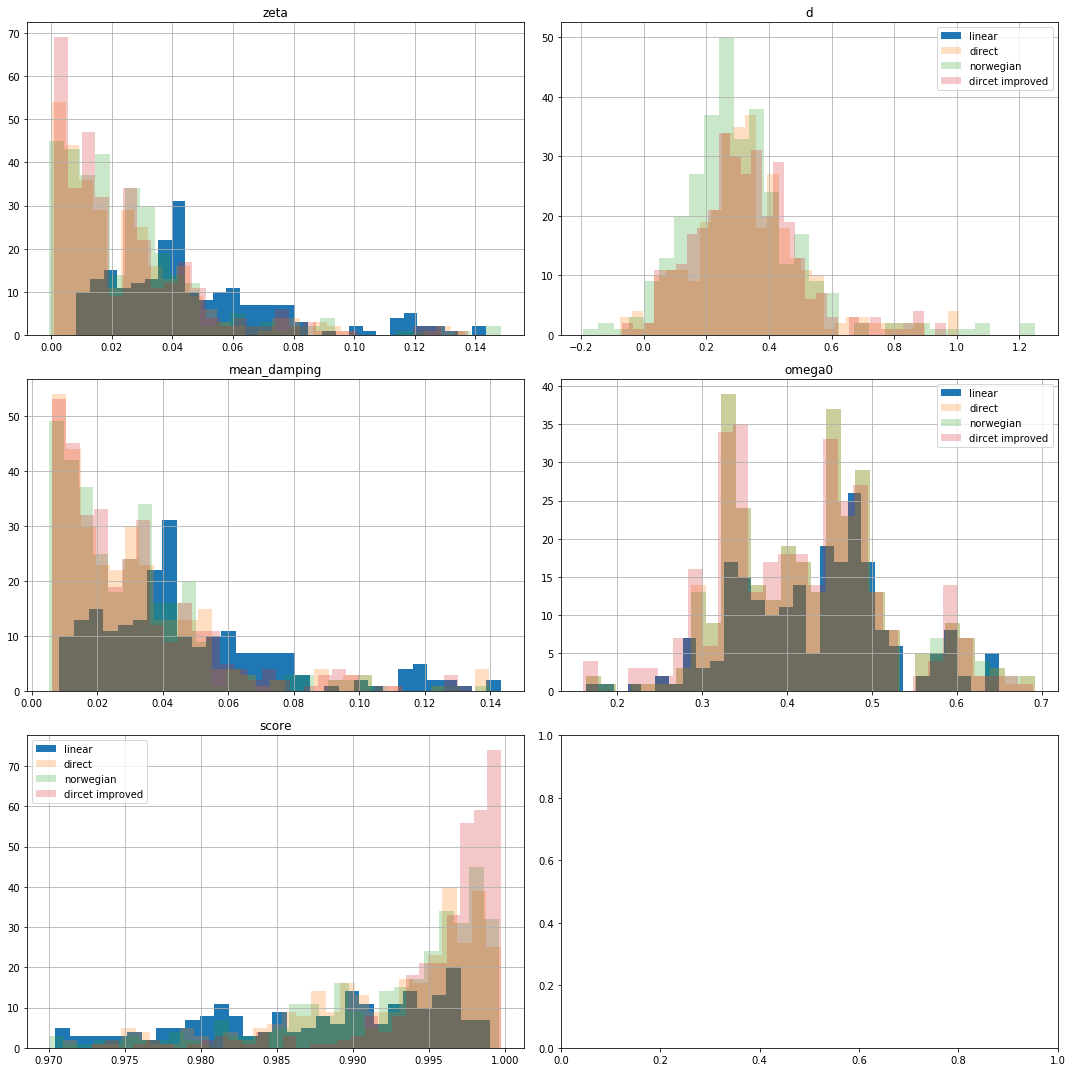

In [47]:
plots = [['zeta','d'],
         ['mean_damping','omega0'],
         ['score'],
        ]
nrows = len(plots)
ncols = 0
for subplots in plots:
    if len(subplots) > ncols:
        ncols = len(subplots)

fig,axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(15,15)

for row, subplots in enumerate(plots):
    for col, plot in enumerate(subplots):
        
        ax = axes[row,col]
        
        bins = 30
        rolldecay_linear[plot].hist(label='linear', bins=bins, ax=ax)
        rolldecay_direct[plot].hist(label='direct', bins=bins, ax=ax, alpha=0.25)
        rolldecay_norwegian[plot].hist(label='norwegian', bins=bins, ax=ax, alpha=0.25)
        rolldecay_direct_improved[plot].hist(label='dircet improved', bins=bins, ax=ax, alpha=0.25)
        
        
        ax.set_title(plot)

    ax.legend()
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

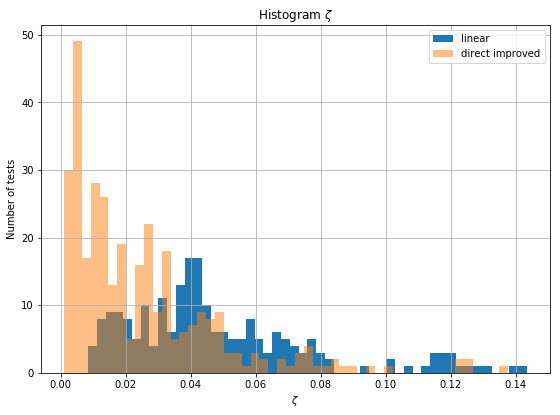

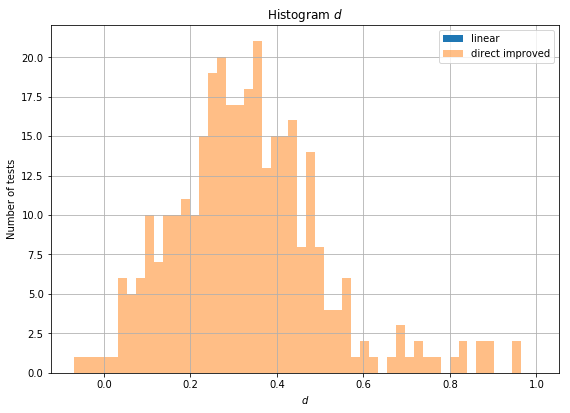

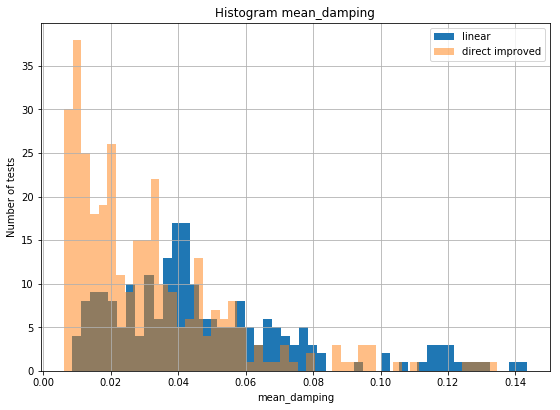

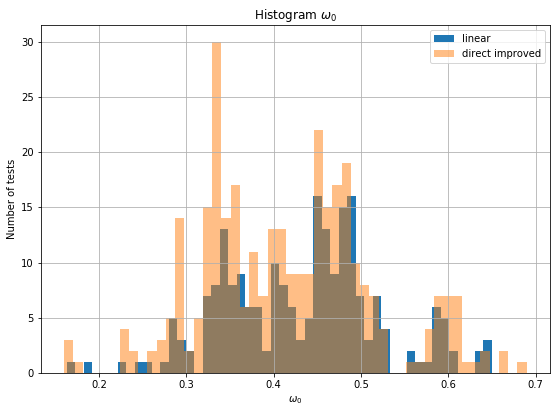

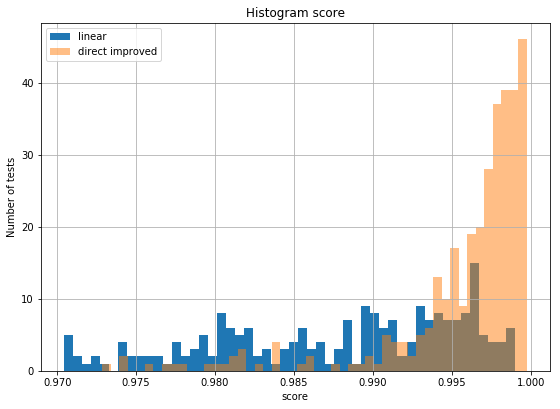

In [48]:
plots= ['zeta','d','mean_damping','omega0','score']

labels = {
    'zeta':'$\zeta$',
    'd':'$d$',
    'omega0':'$\omega_0$',
}

plt.tight_layout()

for plot in plots:
    
    fig,ax = plt.subplots()
    fig.set_size_inches(1.6*np.array([5.7, 4.0]))
       
    bins = 50
    rolldecay_linear[plot].hist(label='linear', bins=bins, ax=ax)
    rolldecay_direct_improved[plot].hist(label='direct improved', bins=bins, ax=ax, alpha=0.5)    
    label = labels.get(plot,plot)
    ax.set_title('Histogram %s' % label)
    ax.set_xlabel(label)
    ax.set_ylabel('Number of tests')
    ax.legend();
    
    file_name = 'histogram_%s.png' % plot
    save_path = os.path.join(docs.path_presentation1,file_name)
    fig.savefig(save_path,transparent=True, dpi=100, bbox_inches='tight')


### Comments

So we now know that mean_damping is in the range 0-0.15...

In [49]:
rolldecay_linear.describe()

,d,mean_damping,omega0,score,zeta
count,0.0,217.000000,219.000000,219.000000,217.000000
mean,NaN,0.048195,0.433172,0.987827,0.048195
std,NaN,0.028898,0.089450,0.007738,0.028898
min,NaN,0.008367,0.163535,0.970429,0.008367
25%,NaN,0.028175,0.359733,0.981461,0.028175
50%,NaN,0.041762,0.447844,0.989724,0.041762
75%,NaN,0.060760,0.486179,0.994641,0.060760
max,NaN,0.143350,0.649662,0.998985,0.143350


In [50]:
rolldecay_direct.describe()

,d,mean_damping,omega0,score,zeta
count,315.000000,312.000000,314.000000,313.000000,312.000000
mean,0.336114,0.030990,0.425872,0.992477,0.024451
std,0.182861,0.024912,0.094370,0.006329,0.023360
min,-0.074307,0.006136,0.163377,0.970944,0.000324
25%,0.234850,0.012499,0.347272,0.989030,0.006751
50%,0.319487,0.025213,0.428230,0.994795,0.017383
75%,0.428426,0.040858,0.484027,0.997389,0.032857
max,1.008231,0.139697,0.692322,0.999717,0.136445


In [51]:
rolldecay_norwegian.describe()

,d,mean_damping,omega0,score,zeta
count,318.000000,317.000000,318.000000,317.000000,319.000000
mean,0.313011,0.029739,0.429298,0.992524,0.024789
std,0.202679,0.022531,0.096513,0.006674,0.023462
min,-0.192577,0.005408,0.163377,0.970060,-0.000511
25%,0.196946,0.012683,0.348426,0.988973,0.008140
50%,0.284463,0.025013,0.431966,0.995096,0.018302
75%,0.391115,0.038974,0.486371,0.997597,0.032263
max,1.250149,0.139938,0.692322,0.999614,0.148451


In [52]:
rolldecay_direct_improved.describe()

,d,mean_damping,omega0,dGM,score,zeta
count,332.000000,330.000000,330.000000,332.000000,332.000000,331.000000
mean,0.332449,0.030608,0.416073,0.085288,0.995838,0.024744
std,0.174124,0.023813,0.097763,0.281863,0.004856,0.023800
min,-0.069580,0.006130,0.160194,-0.743202,0.972848,0.000957
25%,0.225857,0.012416,0.338736,0.011451,0.995151,0.006904
50%,0.320596,0.023589,0.411941,0.080549,0.997482,0.017577
75%,0.425874,0.039717,0.477691,0.156542,0.998677,0.032924
max,0.964880,0.134448,0.689777,2.858157,0.999739,0.137707


c:\dev\rolldecay\venv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """
c:\dev\rolldecay\venv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  
c:\dev\rolldecay\venv\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

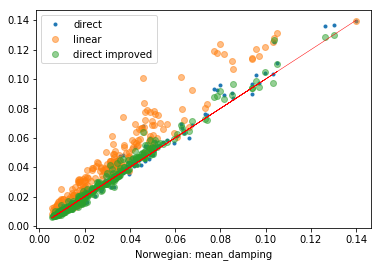

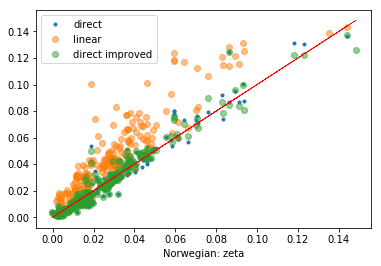

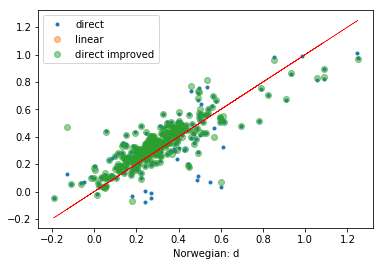

In [53]:
for key in ['mean_damping','zeta','d']:
    
    fig,ax = plt.subplots()
    x = rolldecay_norwegian[key]
    y = rolldecay_direct.loc[rolldecay_norwegian.index][key]
    y2 = rolldecay_linear.loc[rolldecay_norwegian.index][key]    
    y3 = rolldecay_direct_improved.loc[rolldecay_norwegian.index][key]
    
    ax.plot(x,y,'.', label='direct')
    ax.plot(x,y2,'o', label='linear', alpha=0.5)
    ax.plot(x,y3,'o', label='direct improved', alpha=0.5)
    
    ax.set_xlabel('Norwegian: %s' % key)
    ax.legend();
    ax.plot(x,x,'r-')
    


### Comments
* Norwegian method and direct method give differnet results which is not very satisfying.
* Linear method gives higher mean damping, which is a bit strange.

In [54]:
sql="""
SELECT * from
rolldecay_linear
INNER JOIN run
ON rolldecay_linear.run_id == run.id
    INNER JOIN loading_conditions
    ON run.loading_condition_name == loading_conditions.name
        INNER JOIN models
        ON run.model_number == models.model_number
            INNER JOIN ships
            ON models.ship_name == ships.name

"""
df_rolldecay = pd.read_sql(sql, con=engine, index_col='run_id',)
df_rolldecay = df_rolldecay.loc[:,~df_rolldecay.columns.duplicated()]
df_rolldecay = remove_outliers(df_rolldecay)
df_rolldecay.describe()

,d,mean_damping,omega0,score,zeta,id,project_number,series_number,run_number,test_number,ship_speed,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,PDTDES,RTYPE,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,HSKEG,RSKEG,LOA
count,0.0,1012.000000,1016.000000,1011.000000,1012.000000,1025.000000,9.810000e+02,1003.000000,1004.000000,0.0,957.000000,1022.000000,1002.000000,982.000000,791.000000,985.000000,985.000000,774.000000,778.000000,776.000000,665.000000,798.000000,982.000000,801.000000,786.000000,995.000000,953.000000,990.000000,556.000000,785.000000,0.0,488.000000,768.000000,574.000000,592.000000,765.000000,395.000000,767.000000,15.0,782.000000,758.000000,0.0,814.000000,597.000000,8.000000,576.000000,731.000000,810.000000,0.0,0.0,0.0,0.0,572.000000,574.000000,505.000000,808.000000
mean,NaN,0.047222,0.425228,0.988934,0.047222,10773.116098,2.063123e+07,9.765703,26.297809,NaN,13.563532,-0.410547,15.483422,4.230196,0.855722,10.950254,10.773706,43.961667,14.865476,63.144034,2.675598,0.772705,99709.765784,0.991503,9.060891,52.354057,264.929286,43.059152,43.127878,-1.007153,NaN,8.690471,18.985391,9.772561,131.854730,0.894725,10.480000,20332.225554,3.0,79.325754,0.408500,NaN,7.785553,29.663652,2.664500,-118.601389,79.392750,51.819111,NaN,NaN,NaN,NaN,-137.034073,7.804547,19.376238,281.476906
std,NaN,0.019703,0.073470,0.006837,0.019703,5629.644440,2.843164e+06,13.791357,10.871311,NaN,7.035371,3.655076,3.292352,2.127159,0.024010,2.265116,2.625764,5.458019,2.045351,8.617582,0.454462,0.031000,36695.074679,0.003677,1.519267,7.709676,44.895196,7.349123,19.863901,7.010785,NaN,0.610817,1.585399,0.869943,27.195367,0.106859,3.151003,4785.985044,0.0,13.312772,0.050314,NaN,0.981627,4.854611,0.026849,11.567094,11.767049,14.742069,NaN,NaN,NaN,NaN,13.017645,0.542316,9.941667,34.675468
min,NaN,0.012273,0.246318,0.970429,0.012273,832.000000,2.006417e+07,1.000000,3.000000,NaN,1.000000,-9.514000,4.880000,0.570000,0.769000,3.150000,1.500000,15.860000,5.180000,24.000000,1.660000,0.632500,817.000000,0.979300,3.180000,24.000000,89.600000,15.010000,5.900000,-11.680000,NaN,5.400000,13.800000,6.890000,52.000000,0.700000,6.800000,2385.000000,3.0,24.190000,0.250000,NaN,2.700000,14.000000,2.650000,-139.500000,68.300000,7.000000,NaN,NaN,NaN,NaN,-151.000000,6.200000,1.100000,109.930000
25%,NaN,0.035664,0.365044,0.984755,0.035664,7497.000000,2.010554e+07,1.000000,20.000000,NaN,11.000000,-2.750000,14.680000,3.000000,0.847000,11.480000,11.000000,44.000000,14.300000,64.100000,2.430000,0.762800,96431.000000,0.989800,8.200000,50.000000,278.000000,44.000000,43.600000,-7.665000,NaN,8.400000,19.400000,9.250000,121.000000,0.870000,6.950000,18818.000000,3.0,66.725000,0.400000,NaN,7.800000,25.000000,2.650000,-123.000000,73.000000,42.600000,NaN,NaN,NaN,NaN,-142.000000,7.600000,11.100000,290.000000
50%,NaN,0.043495,0.416300,0.990278,0.043495,8930.000000,2.012625e+07,10.000000,27.000000,NaN,17.000000,-0.820000,16.950000,3.820000,0.854000,11.500000,11.500000,45.800000,15.310000,65.210000,2.650000,0.774000,114188.000000,0.992000,9.350000,55.000000,279.000000,45.800000,50.800000,0.000000,NaN,8.400000,19.500000,9.730000,136.000000,0.871000,10.300000,20000.000000,3.0,82.890000,0.430000,NaN,8.000000,30.000000,2.650000,-122.000000,77.000000,49.400000,NaN,NaN,NaN,NaN,-140.200000,7.800000,17.200000,290.000000
75%,NaN,0.059403,0.484958,0.994599,0.059403,15081.000000,2.013686e+07,11.000000,32.000000,NaN,18.800000,0.160000,17.400000,4.900000,0.869000,11.500000,11.500000,46.950000,15.500000,66.190000,3.010000,0.796500,118316.000000,0.992800,10.200000,56.460000,284.000000,46.950000,56.800000,2.100000,NaN,9.000000,19.800000,10.000000,150.000000,0.992000,11.800000,23600.000000,3.0,90.550000,0.440000,NaN,8.300000,34.000000,2.664500,-118.000000,79.300000,65.280000,NaN,NaN,NaN,NaN,-139.000000,8.000000,28.000000,292.750000
max,NaN,0.120573,0.640932,0.998673,0.120573,20497.000000,4.008482e+07,101.000000,68.000000,NaN,2

In [55]:
df_rolldecay.columns

Index(['d', 'mean_damping', 'omega0', 'score', 'zeta', 'id', 'project_number',
       'series_number', 'run_number', 'test_number', 'model_number',
       'ship_name', 'loading_condition_name', 'ascii_name', 'ship_speed',
       'comment', 'file_path_ascii', 'file_path_log', 'file_path_hdf5', 'date',
       'test_type', 'facility', 'angle1', 'angle2', 'name', 'lcg', 'kg', 'gm',
       'CW', 'TF', 'TA', 'BWL', 'KXX', 'KZZ', 'BTT1', 'CP', 'Volume', 'A0',
       'RH', 'scale_factor', 'lpp', 'beam', 'ABULB', 'BKX', 'TWIN', 'DCLR',
       'VDES', 'RHBL', 'ASKEG', 'PD', 'ARH', 'CFP', 'AIX', 'PDTDES', 'RTYPE',
       'SFP', 'BKL', 'BKB', 'PROT', 'D', 'LSKEG', 'RR', 'XSKEG', 'NDES', 'AR',
       'BR', 'BRA', 'IRUD', 'PTYPE', 'XRUD', 'AI', 'HSKEG', 'RSKEG', 'LOA'],
      dtype='object')

In [56]:
df_rolldecay.describe()

,d,mean_damping,omega0,score,zeta,id,project_number,series_number,run_number,test_number,ship_speed,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,PDTDES,RTYPE,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,HSKEG,RSKEG,LOA
count,0.0,1012.000000,1016.000000,1011.000000,1012.000000,1025.000000,9.810000e+02,1003.000000,1004.000000,0.0,957.000000,1022.000000,1002.000000,982.000000,791.000000,985.000000,985.000000,774.000000,778.000000,776.000000,665.000000,798.000000,982.000000,801.000000,786.000000,995.000000,953.000000,990.000000,556.000000,785.000000,0.0,488.000000,768.000000,574.000000,592.000000,765.000000,395.000000,767.000000,15.0,782.000000,758.000000,0.0,814.000000,597.000000,8.000000,576.000000,731.000000,810.000000,0.0,0.0,0.0,0.0,572.000000,574.000000,505.000000,808.000000
mean,NaN,0.047222,0.425228,0.988934,0.047222,10773.116098,2.063123e+07,9.765703,26.297809,NaN,13.563532,-0.410547,15.483422,4.230196,0.855722,10.950254,10.773706,43.961667,14.865476,63.144034,2.675598,0.772705,99709.765784,0.991503,9.060891,52.354057,264.929286,43.059152,43.127878,-1.007153,NaN,8.690471,18.985391,9.772561,131.854730,0.894725,10.480000,20332.225554,3.0,79.325754,0.408500,NaN,7.785553,29.663652,2.664500,-118.601389,79.392750,51.819111,NaN,NaN,NaN,NaN,-137.034073,7.804547,19.376238,281.476906
std,NaN,0.019703,0.073470,0.006837,0.019703,5629.644440,2.843164e+06,13.791357,10.871311,NaN,7.035371,3.655076,3.292352,2.127159,0.024010,2.265116,2.625764,5.458019,2.045351,8.617582,0.454462,0.031000,36695.074679,0.003677,1.519267,7.709676,44.895196,7.349123,19.863901,7.010785,NaN,0.610817,1.585399,0.869943,27.195367,0.106859,3.151003,4785.985044,0.0,13.312772,0.050314,NaN,0.981627,4.854611,0.026849,11.567094,11.767049,14.742069,NaN,NaN,NaN,NaN,13.017645,0.542316,9.941667,34.675468
min,NaN,0.012273,0.246318,0.970429,0.012273,832.000000,2.006417e+07,1.000000,3.000000,NaN,1.000000,-9.514000,4.880000,0.570000,0.769000,3.150000,1.500000,15.860000,5.180000,24.000000,1.660000,0.632500,817.000000,0.979300,3.180000,24.000000,89.600000,15.010000,5.900000,-11.680000,NaN,5.400000,13.800000,6.890000,52.000000,0.700000,6.800000,2385.000000,3.0,24.190000,0.250000,NaN,2.700000,14.000000,2.650000,-139.500000,68.300000,7.000000,NaN,NaN,NaN,NaN,-151.000000,6.200000,1.100000,109.930000
25%,NaN,0.035664,0.365044,0.984755,0.035664,7497.000000,2.010554e+07,1.000000,20.000000,NaN,11.000000,-2.750000,14.680000,3.000000,0.847000,11.480000,11.000000,44.000000,14.300000,64.100000,2.430000,0.762800,96431.000000,0.989800,8.200000,50.000000,278.000000,44.000000,43.600000,-7.665000,NaN,8.400000,19.400000,9.250000,121.000000,0.870000,6.950000,18818.000000,3.0,66.725000,0.400000,NaN,7.800000,25.000000,2.650000,-123.000000,73.000000,42.600000,NaN,NaN,NaN,NaN,-142.000000,7.600000,11.100000,290.000000
50%,NaN,0.043495,0.416300,0.990278,0.043495,8930.000000,2.012625e+07,10.000000,27.000000,NaN,17.000000,-0.820000,16.950000,3.820000,0.854000,11.500000,11.500000,45.800000,15.310000,65.210000,2.650000,0.774000,114188.000000,0.992000,9.350000,55.000000,279.000000,45.800000,50.800000,0.000000,NaN,8.400000,19.500000,9.730000,136.000000,0.871000,10.300000,20000.000000,3.0,82.890000,0.430000,NaN,8.000000,30.000000,2.650000,-122.000000,77.000000,49.400000,NaN,NaN,NaN,NaN,-140.200000,7.800000,17.200000,290.000000
75%,NaN,0.059403,0.484958,0.994599,0.059403,15081.000000,2.013686e+07,11.000000,32.000000,NaN,18.800000,0.160000,17.400000,4.900000,0.869000,11.500000,11.500000,46.950000,15.500000,66.190000,3.010000,0.796500,118316.000000,0.992800,10.200000,56.460000,284.000000,46.950000,56.800000,2.100000,NaN,9.000000,19.800000,10.000000,150.000000,0.992000,11.800000,23600.000000,3.0,90.550000,0.440000,NaN,8.300000,34.000000,2.664500,-118.000000,79.300000,65.280000,NaN,NaN,NaN,NaN,-139.000000,8.000000,28.000000,292.750000
max,NaN,0.120573,0.640932,0.998673,0.120573,20497.000000,4.008482e+07,101.000000,68.000000,NaN,2

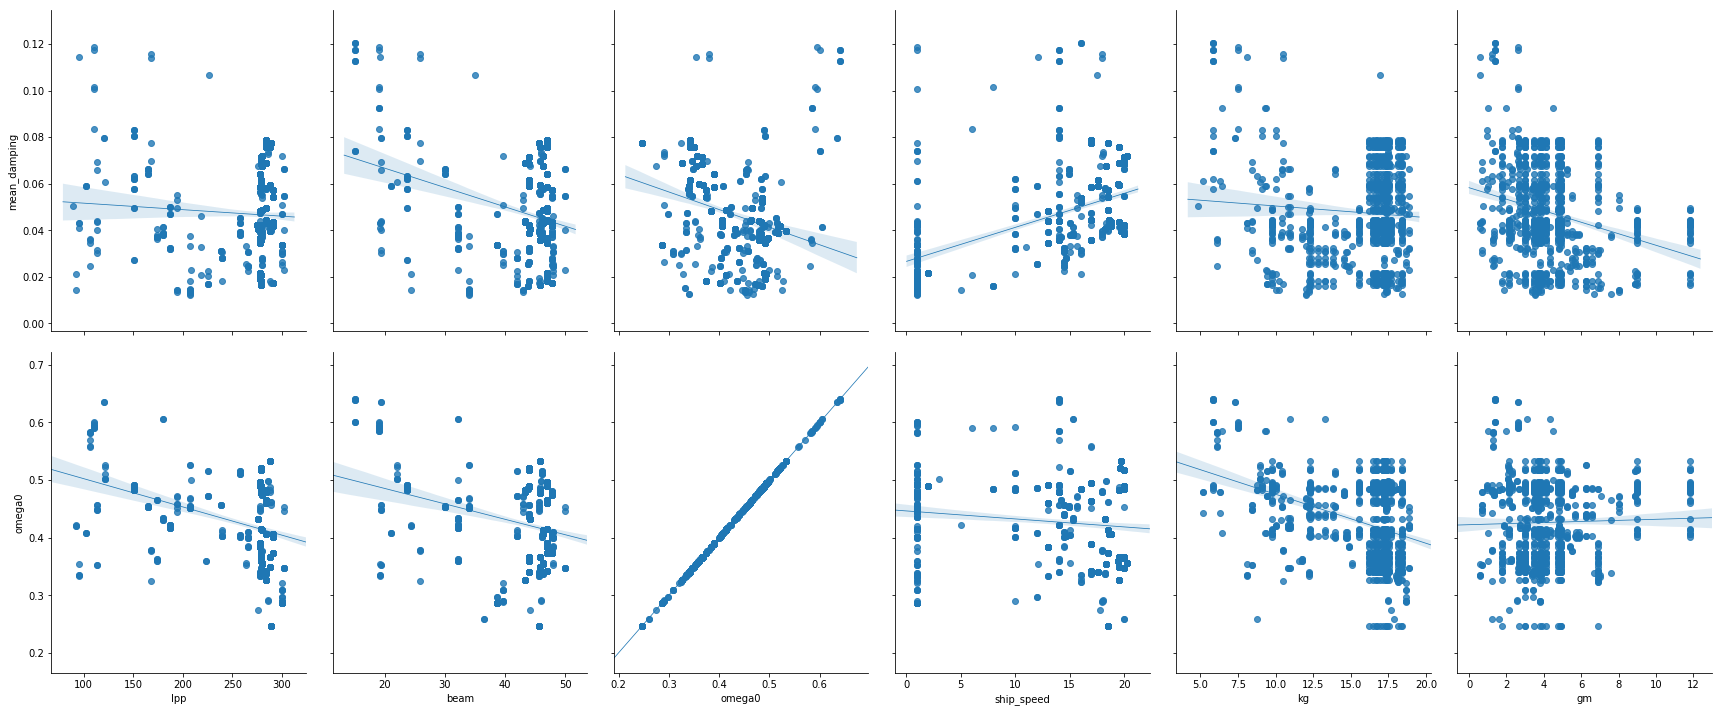

In [77]:
x_vars = ['lpp','beam','omega0','ship_speed','kg','gm']
sns.pairplot(df_rolldecay, x_vars=x_vars, y_vars=['mean_damping','omega0'],
             height=5, aspect=.8, kind="reg");

In [78]:
df_rolldecay.columns

Index(['d', 'mean_damping', 'omega0', 'score', 'zeta', 'id', 'project_number',
       'series_number', 'run_number', 'test_number', 'model_number',
       'ship_name', 'loading_condition_name', 'ascii_name', 'ship_speed',
       'comment', 'file_path_ascii', 'file_path_log', 'file_path_hdf5', 'date',
       'test_type', 'facility', 'angle1', 'angle2', 'name', 'lcg', 'kg', 'gm',
       'CW', 'TF', 'TA', 'BWL', 'KXX', 'KZZ', 'BTT1', 'CP', 'Volume', 'A0',
       'RH', 'scale_factor', 'lpp', 'beam', 'ABULB', 'BKX', 'TWIN', 'DCLR',
       'VDES', 'RHBL', 'ASKEG', 'PD', 'ARH', 'CFP', 'AIX', 'PDTDES', 'RTYPE',
       'SFP', 'BKL', 'BKB', 'PROT', 'D', 'LSKEG', 'RR', 'XSKEG', 'NDES', 'AR',
       'BR', 'BRA', 'IRUD', 'PTYPE', 'XRUD', 'AI', 'HSKEG', 'RSKEG', 'LOA'],
      dtype='object')

In [85]:
df_rolldecay.isnull().sum().sort_values(ascending=False)

d                         1042
comment                   1042
CFP                       1042
test_type                 1042
TWIN                      1042
ship_name                 1042
loading_condition_name    1042
ascii_name                1042
file_path_ascii           1042
SFP                       1042
file_path_log             1042
file_path_hdf5            1042
date                      1042
name                      1042
angle2                    1042
angle1                    1042
AIX                       1042
facility                  1042
BRA                       1042
model_number              1042
PTYPE                     1042
BR                        1042
PROT                      1042
test_number               1042
AI                        1042
IRUD                      1042
RR                        1034
RTYPE                     1027
ARH                        647
DCLR                       554
RSKEG                      537
ABULB                      486
XRUD    

In [126]:
important = ['KXX',                        
'BKL',                        
'BKX',                        
'RH',                         
'CW',                         
'CP',                         
'A0',                         
'LOA',                        
'AR',                         
'D',                          
'lpp',                        
'ship_speed',                 
'Volume',                     
'gm',                         
'TA',                         
'TF',                         
'beam',                       
'kg',                         
'lcg']                        
mask = df_rolldecay[important].notnull().all(axis=1)
df = df_rolldecay.loc[mask].copy()

In [127]:
df = df.dropna(subset=['omega0'])

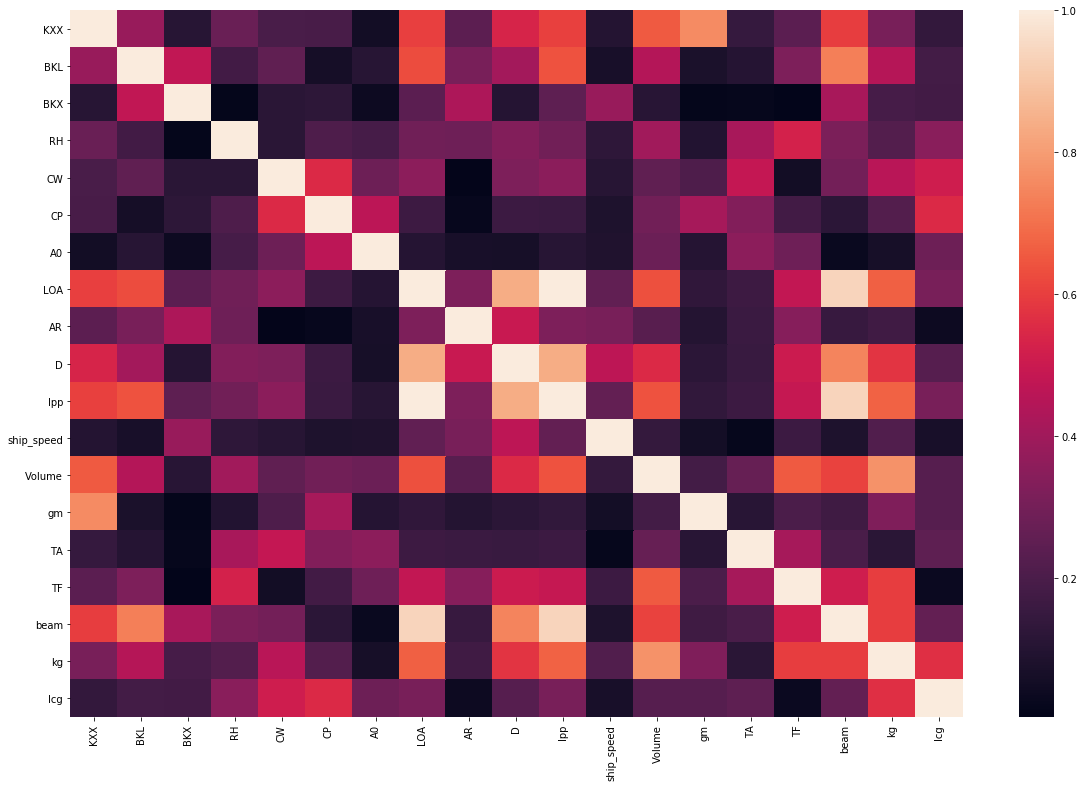

In [128]:
data = df[important].copy()
corr = data.corr().abs()
ax = sns.heatmap(corr)
ax.figure.set_size_inches(20,13)

In [129]:
len(data)

538

In [132]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

polynomial_features = PolynomialFeatures(degree=3)
linear_regression = LinearRegression()
model = make_pipeline(polynomial_features, linear_regression)

X=data
y=df['omega0']

model.fit(X=X, y=y)
model.score(X=X, y=y)

0.7284239695211894

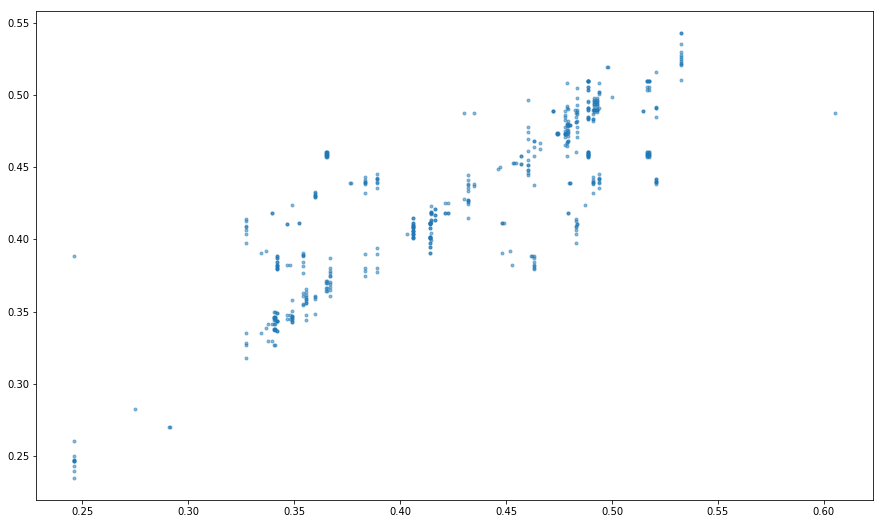

In [133]:
fig,ax = plt.subplots()
ax.plot(y,model.predict(X),'.', alpha=0.5)

In [111]:
cv_results

{'fit_time': array([0.21794748, 0.21287727, 0.20488238]),
 'score_time': array([0.00499821, 0.00599718, 0.00499797]),
 'test_score': array([-12610998.89137548,   -916156.21165571, -20388067.43485899])}

Text(0.5, 1.0, 'kxx')

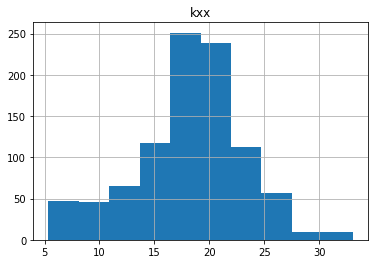

In [27]:
omega0 = df_rolldecay['omega0']
GM = df_rolldecay['gm']
g = 9.81
kxx = 1/omega0*np.sqrt(g*GM)  # "Sunes equation"
fig,ax = plt.subplots()
kxx.hist(ax=ax);
ax.set_title('kxx')


## Comment
kxx should be nondimensional rxx/beam which is clearly not the case...

In [28]:
df_rolldecay['beam_'] = df_rolldecay['beam']/df_rolldecay['lpp']

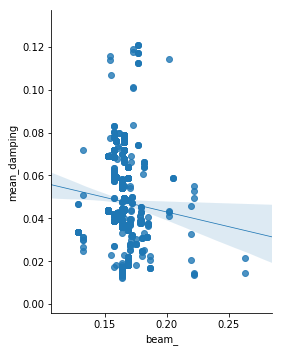

In [29]:
x_vars = ['beam_']
sns.pairplot(df_rolldecay, x_vars=x_vars, y_vars=['mean_damping'],
             height=5, aspect=.8, kind="reg");